In [1]:
import math, pandas as pd, numpy as np
import matplotlib.pyplot as plt

# The purpose of this notebooks is to estimate a transition rate from MAM to recovered from MAM (mild child wasting) in untreated populations

## Data to inform this transition rate is informed from the James et al. paper 

    (James, P., Sadler, K., Wondafrash, M., Argaw, A., Luo, H., Geleta, B., Kedir, K., Getnet, Y., Belachew, T., & Bahwere, P. (2016). Children with Moderate Acute Malnutrition with No Access to Supplementary Feeding Programmes Experience High Rates of Deterioration and No Improvement: Results from a Prospective Cohort Study in Rural Ethiopia. PloS one, 11(4), e0153530. https://doi.org/10.1371/journal.pone.0153530)
    
 

The paper recruited children with MAM at baseline in an area without access to MAM treatment and followed them weekly for 28 weeks. The paper stated that **among children who recovered from MAM during the follow-up period of 28 weeks, the median time to recovery was 9 weeks**. Information on outcomes at the end of study follow-up among the cohort are presented in the table below.

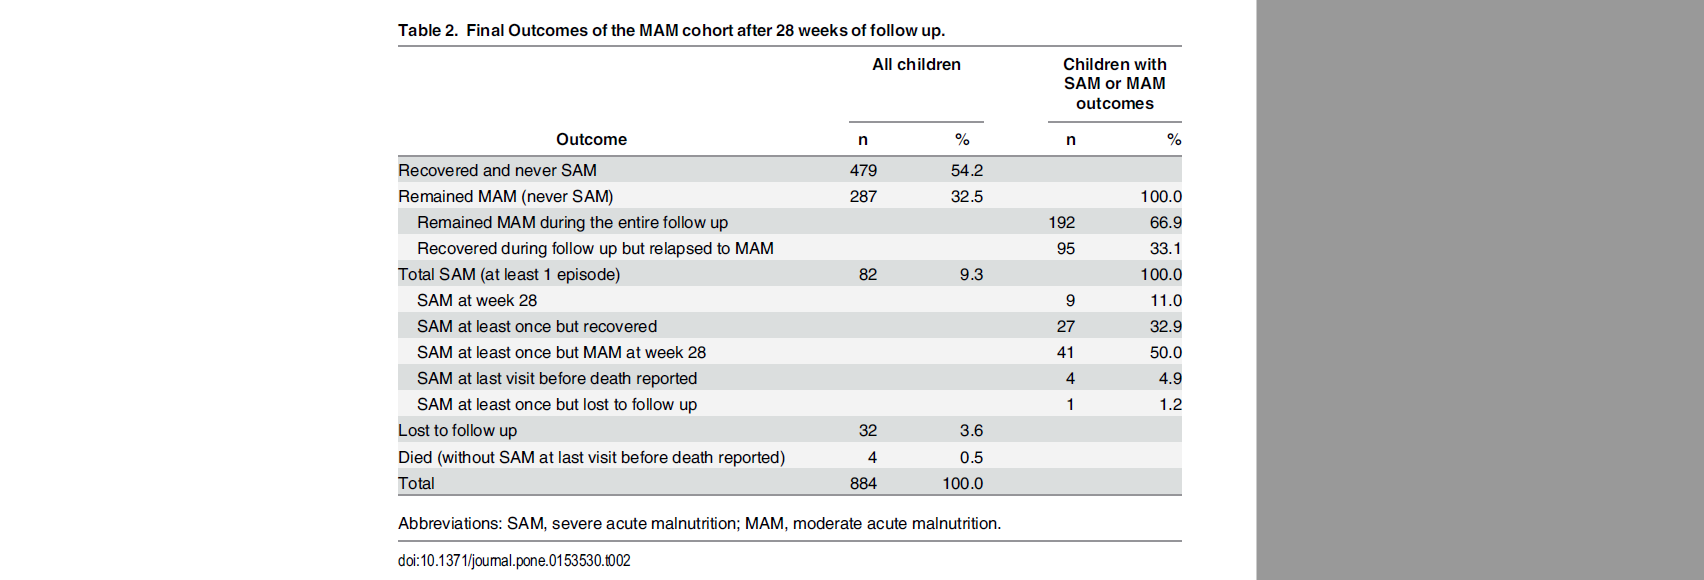



In [2]:
# proportion of children who died while in the MAM state who were not lost to follow-up
4/(884-32)
# less than one percent, so let's ignore mortality for now

0.004694835680751174

In [3]:
n_total_adjusted = 884 - 32 - 4 # total minus those lost to follow-up and those who died
n_recovered_during_followup = 479 + 95
n_remained_mam_for_all_of_followup = 192
n_progressed_to_sam = 82

In [14]:
n_recovered_during_followup / n_total_adjusted

0.6768867924528302

Additionally, the paper estimated the incidence rate of SAM among the cohort afflicted with MAM

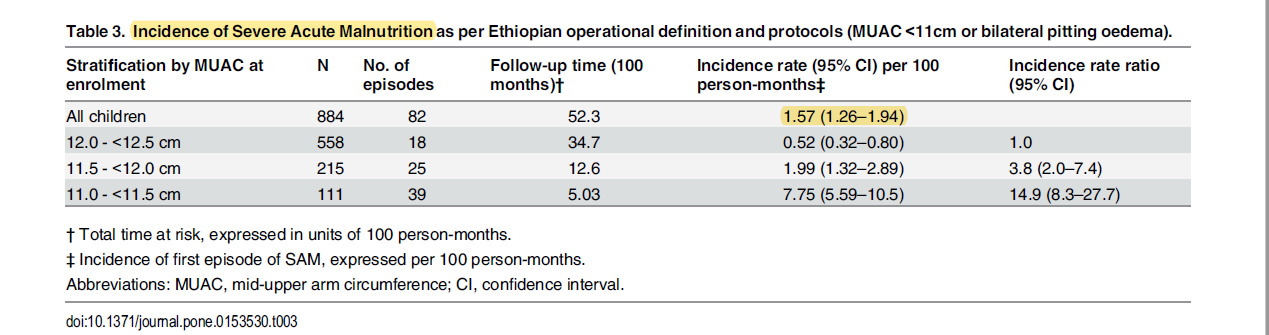

In [4]:
# convert incidence rate per 100 person-months to incidence rate per person-week

print('incidence rate from MAM to SAM in person-weeks:',
      np.round(1.57 / 100 * 12 / 52, 4),
      ' (95% CI', 
      np.round(1.26 / 100 * 12 / 52, 4),
      ', ',
      np.round(1.94 / 100 * 12 / 52, 4),
      ')')

incidence rate from MAM to SAM in person-weeks: 0.0036  (95% CI 0.0029 ,  0.0045 )


In [5]:
duration = 21 #weeks!
rate = 1/duration

In [6]:
n_sims = 10000

sim = pd.DataFrame()
sim['simulant'] = list(range(1,n_sims+1))
sim['propensity'] = np.random.uniform(size=n_sims)
sim['t_0'] = 'mam'

# take week long time steps
for t in list(range(1,32)):
    sim['propensity'] = np.random.uniform(size=n_sims)
    sim[f't_{t}'] = np.where(sim[f't_{t-1}'].isin(['recovered','sam']), sim[f't_{t-1}'],
                             np.where(sim.propensity <= rate, 'recovered',
                                      np.where(sim.propensity >= (1-0.0036), 'sam',sim[f't_{t-1}'])))
sim

,simulant,propensity,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31
0,1,0.243445,mam,mam,mam,mam,mam,mam,mam,mam,...,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered
1,2,0.717328,mam,mam,mam,recovered,recovered,recovered,recovered,recovered,...,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered
2,3,0.468705,mam,mam,mam,mam,mam,mam,recovered,recovered,...,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered
3,4,0.896413,mam,mam,mam,mam,mam,mam,mam,mam,...,mam,mam,mam,mam,mam,recovered,recovered,recovered,recovered,recovered
4,5,0.485071,mam,mam,mam,mam,mam,mam,mam,mam,...,mam,mam,mam,mam,mam,mam,mam,mam,mam,mam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0.983417,mam,mam,mam,mam,mam,mam,mam,mam,...,mam,mam,mam,mam,mam,recovered,recovered,recovered,recovered,recovered
9996,9997,0.141321,mam,mam,mam,mam,mam,mam,mam,mam,...,mam,mam,mam,mam,mam,mam,mam,recovered,recovered,recovered
9997,9998,0.165350,mam,mam,mam,mam,mam,mam,mam,mam,...,mam,mam,mam,mam,mam,mam,mam,mam,mam,mam
9998,9999,0.188269,mam,mam,mam,mam,recovered,recovered,recovered,recovered,...,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered,recovered


In [7]:
t = sim.stack().reset_index()
t = t.loc[t.level_1.str.contains('t_')]
t['count_recovered'] = np.where(t[0]=='recovered', 1, 0)
t['count_left_mam'] = np.where(t[0].isin(['recovered','sam']), 1, 0)

t = t.groupby('level_1').sum()[['count_recovered','count_left_mam']].reset_index()
t['t'] = t.level_1.str.replace('t_','').astype(int)
t = t.sort_values(by='t').drop(columns='level_1')
t['count_recovered'] = t['count_recovered'] / n_sims
t['count_left_mam'] = t['count_left_mam'] / n_sims
t

,count_recovered,count_left_mam,t
0,0.0000,0.0000,0
1,0.0472,0.0506,1
12,0.0914,0.0980,2
23,0.1343,0.1452,3
26,0.1768,0.1910,4
27,0.2144,0.2306,5
28,0.2491,0.2677,6
29,0.2854,0.3067,7
30,0.3164,0.3404,8
31,0.3477,0.3739,9


Text(0.5, 1.0, 'Simulation of MAM transition rates from James paper')

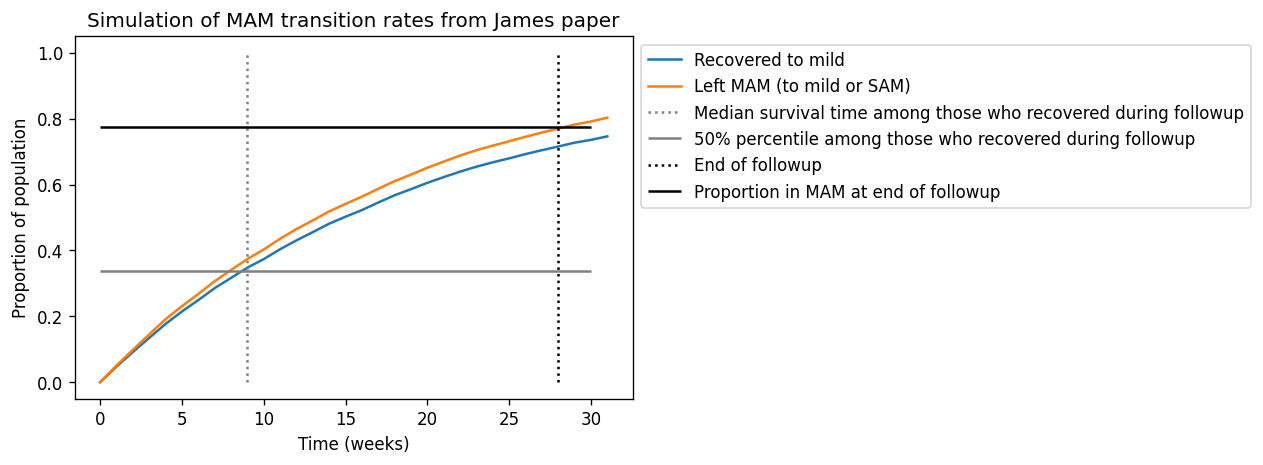

In [8]:
plt.figure(dpi=120)

plt.plot(t.t, t['count_recovered'], label='Recovered to mild')
plt.plot(t.t, t.count_left_mam, label='Left MAM (to mild or SAM)')

plt.vlines(x=9, ymin=0, ymax=1, linestyle='dotted', color='gray', 
           label='Median survival time among those who recovered during followup')

plt.hlines(y=(n_recovered_during_followup/n_total_adjusted)*0.5, 
           xmin=0, xmax=30, linestyle='solid', color='gray',
          label='50% percentile among those who recovered during followup')

plt.vlines(x=28, ymin=0, ymax=1, linestyle='dotted', color='black',
          label='End of followup')

plt.hlines(y= 1 - ((n_remained_mam_for_all_of_followup)/n_total_adjusted)
           , xmin=0, xmax=30, linestyle='solid', color='black',
          label='Proportion in MAM at end of followup')

plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('Time (weeks)')
plt.ylabel('Proportion of population')
plt.title('Simulation of MAM transition rates from James paper')



# ideally, we want the blue line to intersect with the grey lines
# and the orange line to intersect with the black lines

# "time to response" of 21 weeks appears to satisfy that criteria

In [9]:
# rate in person-weeks

rate

0.047619047619047616

In [11]:
# rate in person-years
rate * 52

2.4761904761904763

In [12]:
# current sim value is ~5.7
# KI median value is ~2.5 with a large spread


# so, let's update MAM to mild untreated time to response from 9 to 21 weeks

# but what to do about uncertainty???